# Libraries

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import shutil

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from scipy import ndimage

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import filters

from imgaug import augmenters as iaa

from tqdm import tqdm
from pathlib import Path

import cv2
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose

import PIL

from datetime import datetime
import json
import gc

import time
#t_start = time.time()

# ResNext

In [2]:
"""
ResNet code gently borrowed from
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch.nn as nn
from torch.utils import model_zoo

__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = int(math.floor(planes * (base_width / 64)) * groups)


        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

# Global variable

In [3]:
TRAIN_IMG_PATH = "train/images/"
TEST_IMG_PATH = "test/images/"
DEPTH_PATH = "depths.csv"
TRAIN_MASK_PATH = "train/masks/"
TRAIN_INFO_PATH = "train.csv"


# basic parameters
IMG_ORI_SIZE = 101
IMG_TAR_SIZE = 128
SCALE = 1

# Model parameters
START_NEURONS = 16
DROPOUT_RATIO = 0.5

LOAD_CHECKPONT = True

INPUT_CHANNEL = 1

MODEL1_ADAM_LR = 0.01
MODEL1_EPOCHS = 100
MODEL1_BATCH_SIZE = 64
MODEL1_STEPS_PER_EPOCH_TRAIN = 200
MODEL1_LOSS = 'binary_crossentropy'

MODEL2_ADAM_LR = 0.01
MODEL2_EPOCHS = 100
MODEL2_BATCH_SIZE = 64
MODEL2_STEPS_PER_EPOCH_TRAIN = 200
MODEL2_LOSS = 'lovasz_loss'

# ReduceLROnPlateau parameters
MODEL1_REDUCE_FACTOR = 0.5
MODEL1_REDUCE_PATIENT = 5

MODEL2_REDUCE_FACTOR = 0.5
MODEL2_REDUCE_PATIENT = 5

# DICE_BCE_LOSS Parameters
BCE_WEIGHT = 1
DICE_WEIGHT = 0

# Augmentation Parmeters
AUG = True
PAD_METHOD = 'edge'
KFOLD = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# encoding=utf8
import cv2
import numpy as np
from torch import nn
from functools import reduce

################################################################################
# related functions & loss functions
################################################################################


def upsample(img):
    if IMG_ORI_SIZE == IMG_TAR_SIZE:
        return img
    return cv2.resize(img, (IMG_TAR_SIZE, IMG_TAR_SIZE))


def downsample(img):
    if IMG_ORI_SIZE == IMG_TAR_SIZE:
        return img
    return cv2.resize(img, (IMG_ORI_SIZE, IMG_ORI_SIZE))


def add_depth_channels(image_array, depth):
    image_array[:,:,1] = depth
    image_array[:,:,2] = image_array[:,:,0] * image_array[:,:,1]
    return image_array


class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

        
def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True, cls=MyEncoder))
    log.write('\n')
    log.flush()

    
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if torch.cuda.is_available():
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if torch.cuda.is_available():
        return x.cpu().data.numpy()
    return x.data.numpy()


def get_true_target(targets):
    truth_image = targets.squeeze(3).sum(2).sum(1) > 0
    return truth_image
  

def get_logits_outputs(outputs_image, outputs_pixel):
    batch_size, C, H, W = outputs_pixel.shape
    zero_mask = torch.zeros([batch_size, C, H, W], dtype=torch.float).to(device)
    empty_label = outputs_image<0
    outputs_pixel[empty_label] = zero_mask[empty_label]
    return outputs_pixel


def iou_numpy(outputs, labels):
    SMOOTH = 1e-6
    if len(outputs.shape) == 4:
        outputs = outputs.squeeze(1)
    if len(labels.shape) == 4:
        labels = labels.squeeze(1) 
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded.mean()


def my_iou_metric(label, pred):
    return iou_numpy(pred > 0.5, label>0.5)


def my_iou_metric_2(label, pred):
    return iou_numpy(pred > 0, label>0.5)


def my_iou_metric_pad(label, pred):
    pad_size = (IMG_TAR_SIZE-SCALE*IMG_ORI_SIZE)//2
    return iou_numpy(pred[:,:,pad_size:-pad_size-1,pad_size+1:-pad_size]>0,label[:,:,pad_size:-pad_size-1,pad_size+1:-pad_size]>0.5)


def my_iou_metric_pad_thrs(label, pred, thrs):
    pad_size = (IMG_TAR_SIZE-SCALE*IMG_ORI_SIZE)//2
    return iou_numpy(pred[:,:,pad_size:-pad_size-1,pad_size+1:-pad_size]>thrs,label[:,:,pad_size:-pad_size-1,pad_size+1:-pad_size]>0.5)


def my_iou_metric_resize_thrs(label, pred, thrs):
    return iou_numpy(pred>thrs,label>0.5)


def my_iou_metric_fuse_thrs(label, pred_pad, pred_resize, thrs):
    pad_size = (IMG_TAR_SIZE-SCALE*IMG_ORI_SIZE)//2
    label = label[:,:,pad_size:-pad_size-1,pad_size+1:-pad_size]
    pred_pad = pred_pad[:,0,pad_size:-pad_size-1,pad_size+1:-pad_size]
    pred_resize = pred_resize.squeeze(1)
    pred_resize = np.array([downsample(pred_resize_i) for pred_resize_i in pred_resize])
    pred = (pred_pad+pred_resize)/2
    return iou_numpy(pred>thrs,label>0.5)
    

def recover_size_pad(test_image, thre):
    pad_size = (IMG_TAR_SIZE-SCALE*IMG_ORI_SIZE)//2
    recover_logits = downsample(test_image[pad_size:-pad_size-1,pad_size+1:-pad_size])
    recover_binary = np.round(recover_logits > thre)
    return recover_binary


def recover_size(test_image, thre):
    recover_logits = downsample(test_image)
    recover_binary = np.round(recover_logits > thre)
    return recover_binary


def recover_size_pad_resize(test_image_pad, test_image_resize, thre):
    pad_size = (IMG_TAR_SIZE-SCALE*IMG_ORI_SIZE)//2
    recover_logits_pad = downsample(test_image_pad[pad_size:-pad_size-1,pad_size+1:-pad_size])
    recover_logits_resize = downsample(test_image_resize)
    recover_logits = (recover_logits_pad+recover_logits_resize)/2
    recover_binary = np.round(recover_logits > thre)
    return recover_binary
    
    
def save_checkpoint(state, is_best, filename):
    check_filename = 'checkpoint_{}_resize.pth.tar'.format(filename)
    torch.save(state, check_filename)
    if is_best:
        shutil.copyfile(check_filename, 'model_best_{}_resize.pth.tar'.format(filename))
        

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta)

        if patience == 0:
            self.is_better = lambda a, b: True

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if mode == 'min':
            self.is_better = lambda a, best: a < best - min_delta
        if mode == 'max':
            self.is_better = lambda a, best: a > best + min_delta


In [5]:
import torch
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingLR_with_Restart(_LRScheduler):
    """Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:
    .. math::
        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))
    When last_epoch=-1, sets initial lr as lr.
    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. The original pytorch
    implementation only implements the cosine annealing part of SGDR,
    I added my own implementation of the restarts part.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        T_mult (float): Increase T_max by a factor of T_mult
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.
        model (pytorch model): The model to save.
        out_dir (str): Directory to save snapshots
        take_snapshot (bool): Whether to save snapshots at every restart
    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, T_mult, model, out_dir, take_snapshot, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_mult = T_mult
        self.Te = self.T_max
        self.eta_min = eta_min
        self.current_epoch = last_epoch

        self.model = model
        self.out_dir = out_dir
        self.take_snapshot = take_snapshot

        self.lr_history = []

        super(CosineAnnealingLR_with_Restart, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        new_lrs = [self.eta_min + (base_lr - self.eta_min) *
                   (1 + math.cos(math.pi * self.current_epoch / self.Te)) / 2
                   for base_lr in self.base_lrs]

        self.lr_history.append(new_lrs)
        return new_lrs

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

        ## restart
        if self.current_epoch == self.Te:
            print("restart at epoch {:03d}".format(self.last_epoch + 1))

            if self.take_snapshot:
                torch.save({
                    'epoch': self.T_max,
                    'state_dict': self.model.state_dict()
                }, self.out_dir + "Weight/" + 'snapshot_e_{:03d}.pth.tar'.format(self.T_max))

            ## reset epochs since the last reset
            self.current_epoch = 0

            ## reset the next goal
            self.Te = int(self.Te * self.T_mult)
            self.T_max = self.T_max + self.Te

In [6]:
from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse
    

class DiceLoss(nn.Module):
    def __init__(self, smooth=0, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.eps = eps

    def forward(self, output, target):
        output = torch.sigmoid(output)
        return 1 - (2 * torch.sum(output * target) + self.smooth) / (torch.sum(output) + torch.sum(target) + self.smooth + self.eps)


class Dice_Bce_Loss(nn.Module):
    def __init__(self, smooth=0, eps=1e-7, dice_weight=0.5, 
                 dice_loss=None, bce_weight=0.9, bce_loss=None):
        super(Dice_Bce_Loss, self).__init__()
        self.smooth = smooth
        self.eps = eps
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.bce_loss = bce_loss
        self.dice_loss = dice_loss
        
        if self.bce_loss is None:
            self.bce_loss = F.binary_cross_entropy_with_logits
        if self.dice_loss is None:
            self.dice_loss = DiceLoss(smooth, eps)
            
        self.activation = torch.sigmoid
            
    def forward(self, output, target):
        output = self.activation(output)
        return self.dice_weight * self.dice_loss(output, target) + self.bce_weight * self.bce_loss(output, target)


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        

"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.cumsum(0)
    union = gts + (1 - gt_sorted).cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.elu(errors_sorted)+1, grad)
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

# --------------------------- HELPER FUNCTIONS ---------------------------

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


class BCE_Lovaz_Loss(nn.Module):
    def __init__(self, per_image=True, ignore=None):
        super(BCE_Lovaz_Loss, self).__init__()
        self.per_image = per_image
        self.ignore = ignore
        
    def forward(self, logits, targets):
        loss_1 = lovasz_hinge(logits.squeeze(1), targets.squeeze(1), self.per_image, self.ignore)
        loss_2 = nn.BCEWithLogitsLoss()(logits, targets)
        loss = loss_1 + loss_2
        return loss
    
class Lovaz_Loss(nn.Module):
    def __init__(self, per_image=True, ignore=None):
        super(Lovaz_Loss, self).__init__()
        self.per_image = per_image
        self.ignore = ignore
        
    def forward(self, logits, targets):
        loss = lovasz_hinge(logits.squeeze(1), targets.squeeze(1), self.per_image, self.ignore)
        return loss

class Fuse_Loss(nn.Module):
    def __init__(self, pixel_loss_func=Lovaz_Loss(), weight_image=0.05, weight_pixel=0.5, weight=1):
        super(Fuse_Loss, self).__init__()
        self.image_loss_func = F.cross_entropy
        self.pixel_loss_func = pixel_loss_func
        self.activation = torch.sigmoid
        self.weight_image = weight_image
        self.weight_pixel = weight_pixel
        self.weight = weight
        
    def forward(self, logits, logit_pixel, logit_image, truth_pixel, truth_image):
        pixel_non_empty = logit_pixel[truth_image,:,:,:]
        mask_non_empty = truth_pixel[truth_image,:,:,:]
        #loss_pixel = (self.pixel_loss_func(pixel_non_empty, mask_non_empty)+self.pixel_loss_func(-pixel_non_empty, 1-mask_non_empty))/2
        loss_pixel = self.pixel_loss_func(pixel_non_empty, mask_non_empty)
        truth_image = truth_image.type(torch.LongTensor).to(device)
        loss_image = self.image_loss_func(logit_image, truth_image, reduction='elementwise_mean')
        #loss = (self.pixel_loss_func(logits, truth_pixel)+self.pixel_loss_func(-logits, 1-truth_pixel))/2
        loss = self.pixel_loss_func(logits, truth_pixel)
        return self.weight_pixel*loss_pixel + self.weight_image*loss_image + self.weight*loss

In [7]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

ia.seed(2018)

def _standardize(img):
    return (img - img.map(np.mean)) / img.map(np.std)

affine_seq = iaa.Sequential([
    # General
    iaa.SomeOf((1, 2),
               [iaa.Fliplr(0.5),
                iaa.Noop(),
                ]),
    iaa.Affine(rotate=(-5, 5), mode='reflect'),
    iaa.Crop(px=(0, 10)),
], random_order=True)

intensity_seq = iaa.Sequential([
    #iaa.Invert(0.3),
    iaa.Sometimes(0.3, iaa.ContrastNormalization((0.5, 1.5))),
    iaa.OneOf([
        iaa.Noop(),
        iaa.Sequential([
            iaa.OneOf([
                iaa.Add((-10, 10)),
                iaa.AddElementwise((-10, 10)),
                iaa.Multiply((0.95, 1.05)),
                iaa.MultiplyElementwise((0.95, 1.05)),
            ]),
        ]),
        iaa.OneOf([
            iaa.GaussianBlur(sigma=(0.0, 1.0)),
            iaa.AverageBlur(k=(2, 5)),
            #iaa.MedianBlur(k=(3, 5))
        ])
    ])
], random_order=False)

tta_intensity_seq = iaa.Sequential([
    iaa.Noop()
], random_order=False)

def compute_random_pad(limit=(-4,4)):
    dy  = IMG_TAR_SIZE - IMG_ORI_SIZE*SCALE
    dy0 = dy//2 + np.random.randint(limit[0],limit[1]) # np.random.choice(dy)
    dy1 = dy - dy0
    dx0 = dy//2 + np.random.randint(limit[0],limit[1]) # np.random.choice(dy)
    dx1 = dy - dx0
    return dy0, dx0, dy1, dx1

def resize_pad_seq(pad_size):
    dy0, dx0, dy1, dx1 = compute_random_pad()
    seq = iaa.Sequential([
        affine_seq,
        iaa.Scale({'height': IMG_ORI_SIZE*SCALE, 'width': IMG_ORI_SIZE*SCALE}),
        iaa.Pad(px=(dy0, dx0, dy1, dx1), pad_mode='edge', keep_size=False),
    ], random_order=False)
    return seq

def resize_pad_seq_eval(pad_size):
    seq = iaa.Sequential([
        iaa.Scale({'height': IMG_ORI_SIZE*SCALE, 'width': IMG_ORI_SIZE*SCALE}),
        iaa.Pad(px=(pad_size, pad_size, pad_size+1, pad_size+1), pad_mode='edge', keep_size=False),
    ], random_order=False)
    return seq

def resize_seq():
    seq = iaa.Sequential([
        affine_seq,
        iaa.Scale({'height': IMG_TAR_SIZE, 'width': IMG_TAR_SIZE})
    ], random_order=False)
    return seq

def resize_seq_eval():
    seq = iaa.Sequential([
        iaa.Scale({'height': IMG_TAR_SIZE, 'width': IMG_TAR_SIZE})
    ], random_order=False)
    return seq

In [8]:
# encoding=utf8
import numpy as np
import pandas as pd
from functools import partial
import cv2
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose

## convert salt coverage to class
def cov_to_class_1(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7
    
def cov_to_class_2(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i

## used to load data from data files
class my_DataLoader:
    def __init__(self, train=False, test=False, Kfold=False, test_size=0.2):
        self.test = test
        self.train = train
        self.Kfold = Kfold
        self.test_size = test_size
        self.num_fold = int(1/test_size)
            
        train_df, self.test_df = self._load_depth()
        
        if self.train:
            self._load_image_mask(train_df)
            train_df["coverage"] = train_df.masks.map(np.sum) / pow(IMG_ORI_SIZE, 2)
            train_df["coverage_class"] = train_df.masks.map(cov_to_class_1)
            self.x_train, self.x_valid, self.y_train, self.y_valid = self._get_train_test_split(train_df, self.Kfold, self.num_fold)
            
        if self.test:
            self.test_df['images'] = self._load_image_test(self.test_df)
            self.x_test = np.array(self.test_df.images.tolist()).reshape(-1, IMG_ORI_SIZE, IMG_ORI_SIZE, 1)

    @staticmethod
    def _load_image_mask(train_df):
        # load image data & mask data
        train_df['images'] = [np.array(cv2.imread(TRAIN_IMG_PATH + "{}.png".format(idx), 0)) for idx in tqdm_notebook(train_df.index)]
        train_df['masks'] = [np.array(cv2.imread(TRAIN_MASK_PATH + "{}.png".format(idx), 0)) for idx in tqdm_notebook(train_df.index)]
        # Normalize image vectors
        #train_df['images'] /= 255
        #train_df['masks'] /= 255
        
    @staticmethod
    def _load_image_test(test_df):
        return [np.array(cv2.imread(TEST_IMG_PATH + "{}.png".format(idx), 0)) for idx in tqdm_notebook(test_df.index)]

    @staticmethod
    def _load_depth():
        train_df = pd.read_csv(TRAIN_INFO_PATH, index_col="id", usecols=[0])
        depths_df = pd.read_csv(DEPTH_PATH, index_col="id")
        depths_df['z'] = depths_df['z'].astype('float')
        train_df = train_df.join(depths_df)
        test_df = depths_df[~depths_df.index.isin(train_df.index)]
        return train_df, test_df

    ## get train & validation split stratified by salt coverage
    @staticmethod
    def _get_train_test_split(train_df, Kfold, num_fold):
        x_train, x_valid, y_train, y_valid = [], [], [], []
        skf = StratifiedKFold(n_splits=num_fold, random_state=1234, shuffle=True)
        for train_index, valid_index in skf.split(train_df.index.values, train_df.coverage_class):
            x_tr = np.array(train_df.images[train_index].tolist()).reshape(-1, IMG_ORI_SIZE, IMG_ORI_SIZE, 1)
            x_tr = np.append(x_tr, [np.fliplr(x) for x in x_tr], axis=0)
            x_train.append(x_tr)
            x_valid.append(np.array(train_df.images[valid_index].tolist()).reshape(-1, IMG_ORI_SIZE, IMG_ORI_SIZE, 1))
            y_tr = np.array(train_df.masks[train_index].tolist()).reshape(-1, IMG_ORI_SIZE, IMG_ORI_SIZE, 1)
            y_tr = np.append(y_tr, [np.fliplr(y) for y in y_tr], axis=0)
            y_train.append(y_tr)
            y_valid.append(np.array(train_df.masks[valid_index].tolist()).reshape(-1, IMG_ORI_SIZE, IMG_ORI_SIZE, 1))
            if not Kfold:
                break
        return x_train, x_valid, y_train, y_valid

    def get_train(self):
        return self.x_train, self.y_train
    
    def get_valid(self):
        return self.x_valid, self.y_valid

    def get_test_x(self):
        return self.x_test

    def get_test_df(self):
        return self.test_df
    
class ShipDataset(Dataset):
    def __init__(self, data, transform=None, mode='train', fit_method='resize'):
        if mode == 'train' or mode == 'valid':
            self.x = data[0]
            self.y = data[1]
        elif mode == 'test':
            self.data = data
        else:
            raise RuntimeError('MODE_ERROR')
        self.transform = transform
        self.mode = mode
        self.pad_method = PAD_METHOD
        self.pad_size = (IMG_TAR_SIZE-IMG_ORI_SIZE)//2
        
        if fit_method == 'resize_pad':
            self.aug_func_eval = partial(resize_pad_seq_eval, self.pad_size)
        elif fit_method == 'resize':
            self.aug_func_eval = resize_seq_eval
            
        if AUG:
            if fit_method == 'resize_pad':
                self.aug_func = partial(resize_pad_seq, self.pad_size)
            elif fit_method == 'resize':
                self.aug_func = resize_seq
        
        if INPUT_CHANNEL == 3:
            self.depth = np.tile(np.linspace(0,1,IMG_TAR_SIZE),[IMG_TAR_SIZE,1]).T

    def __len__(self):
        if self.mode == 'train' or self.mode == 'valid':
            return len(self.x)
        elif self.mode == 'test':
            return len(self.data)
        else:
            raise RuntimeError('MODE_ERROR')
               
    def __getitem__(self, idx):
        if self.mode == 'train':
            if AUG:
                resize_seq_det = self.aug_func().to_deterministic()
                new_x_batch = resize_seq_det.augment_image(self.x[idx])
                new_x_batch = intensity_seq.augment_image(new_x_batch)/255
                new_y_batch = resize_seq_det.augment_image(self.y[idx])/255
            else:
                resize_seq_det = self.aug_func_eval().to_deterministic()
                new_x_batch = resize_seq_det.augment_image(self.x[idx])/255
                new_y_batch = resize_seq_det.augment_image(self.y[idx])/255
            if INPUT_CHANNEL == 3:
                new_x_batch = np.tile(new_x_batch,(1,1,3))
                new_x_batch = add_depth_channels(new_x_batch, self.depth)
            return new_x_batch, new_y_batch
        elif self.mode == 'valid':
            resize_seq_det = self.aug_func_eval().to_deterministic()
            new_x_batch = resize_seq_det.augment_image(self.x[idx])/255
            new_y_batch = resize_seq_det.augment_image(self.y[idx])/255
            if INPUT_CHANNEL == 3:
                new_x_batch = np.tile(new_x_batch,(1,1,3))
                new_x_batch = add_depth_channels(new_x_batch, self.depth)
            return new_x_batch, new_y_batch
        elif self.mode == 'test':
            resize_seq_det = self.aug_func_eval()
            test_data = resize_seq_det.augment_image(self.data[idx])/255
            if INPUT_CHANNEL == 3:
                test_data = np.tile(test_data,(1,1,3))
                new_x_batch = add_depth_channels(test_data, self.depth)
            return test_data
        else:
            raise RuntimeError('MODE_ERROR')
            
def make_loader(data, batch_size, num_workers=4, shuffle=False, transform=None, mode='train', fit_method='resize'):
        return DataLoader(
            dataset=ShipDataset(data, transform=transform, mode=mode, fit_method=fit_method),
            shuffle=shuffle,
            num_workers = num_workers,
            batch_size = batch_size,
            pin_memory=torch.cuda.is_available()
        )

In [9]:
dl = my_DataLoader(test=True, Kfold=KFOLD)
x_test = dl.get_test_x()
test_df = dl.get_test_df()
dl = my_DataLoader(train=True, Kfold=KFOLD)
x_valid, y_valid = dl.get_valid()

In [10]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision.models.resnet
from torchvision.models.resnet import BasicBlock, Bottleneck
import torch.utils.model_zoo as model_zoo

"""
This script has been taken (and modified) from :
https://github.com/ternaus/TernausNet
@ARTICLE{arXiv:1801.05746,
         author = {V. Iglovikov and A. Shvets},
          title = {TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation},
        journal = {ArXiv e-prints},
         eprint = {1801.05746}, 
           year = 2018
        }
"""

class ConvBn2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, groups=1):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, groups=groups),
                                  nn.BatchNorm2d(out_channels),
                                  )

    def forward(self, x):
        return self.conv(x)


class NoOperation(nn.Module):
    def forward(self, x):
        return x

    
class CSE(nn.Module):
    def __init__(self, in_ch, r=2):
        super(CSE, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear_1 = nn.Linear(in_ch, in_ch//r)
        self.linear_2 = nn.Linear(in_ch//r, in_ch)

        
    def forward(self, x):
        batch_size, channel_num, _, _ = x.size()
        input_x = x

        x = self.avg_pool(x).view(batch_size, channel_num)
        x = F.relu(self.linear_1(x), inplace=True)
        x = self.linear_2(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = torch.sigmoid(x)

        x = torch.mul(x, input_x)

        return x


class SSE(nn.Module):
    def __init__(self, in_ch):
        super(SSE, self).__init__()
        self.conv = nn.Conv2d(in_ch, 1, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        input_x = x

        x = self.conv(x)
        x = torch.sigmoid(x)

        x = torch.mul(x, input_x)

        return x


class SCSE(nn.Module):
    def __init__(self, in_ch, r=2):
        super(SCSE, self).__init__()

        self.cSE = CSE(in_ch, r)
        self.sSE = SSE(in_ch)

    def forward(self, x):
        cSE = self.cSE(x)
        sSE = self.sSE(x)

        x = torch.add(cSE,sSE)

        return x
    
    
class Decoder(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, groups=1):
        super(Decoder, self).__init__()
        self.conv1 = ConvBn2d(in_channels, middle_channels, kernel_size=3, padding=1, groups=groups)
        self.conv2 = ConvBn2d(middle_channels, out_channels, kernel_size=3, padding=1)
        self.SCSE = SCSE(out_channels)
        
    def forward(self, x, e=None):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        if e is not None:
            x = torch.cat([x,e], 1)
            x = F.dropout2d(x, p = 0.50)
            
        x = F.relu(self.conv1(x), inplace=True)
        x = F.relu(self.conv2(x), inplace=True)
        x = self.SCSE(x)

        return x


class UNetResNet34_DS(nn.Module):

    def __init__(self, dropout_2d=0.2, pretrained=True):
        super().__init__()
        self.dropout_2d = dropout_2d

        self.resnet = torchvision.models.resnet34(pretrained=pretrained)

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.encoder2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.resnet.layer1,
        )
        self.encoder3 = self.resnet.layer2
        self.encoder4 = self.resnet.layer3
        self.encoder5 = self.resnet.layer4
        
        self.center = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            )

        self.decoder5 = Decoder(256+512, 512, 64)
        self.decoder4 = Decoder( 64+256, 256, 64)
        self.decoder3 = Decoder( 64+128, 128, 64)
        self.decoder2 = Decoder( 64+ 64,  64, 64)
        self.decoder1 = Decoder( 64+ 64,  32, 64)
        
        self.fuse_pixel = nn.Sequential(
            nn.Conv2d(320, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.logit_pixel  = nn.Sequential(
            nn.Conv2d( 64, 1, kernel_size=1, padding=0),
        )
        
        self.fuse_image = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=1),
            nn.ReLU(inplace=True),
        )

        self.logit_image = nn.Linear(64, 2)
        
        self.logit = nn.Sequential(
            nn.Conv2d(64+64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d( 64,  1, kernel_size=1, padding=0),
        )

    def forward(self, x):
        batch_size, C, H, W = x.shape
        mean= [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        x = torch.cat([
            (x-mean[2])/std[2],
            (x-mean[1])/std[1],
            (x-mean[0])/std[0],
        ],1)
        """
        if INPUT_CHANNEL == 1:
            x = torch.cat([x,x,x],1)
        """
        
        e1 = self.encoder1(x) #;print('e1', e1.size())
        e2 = self.encoder2(e1)#;print('e2', e2.size())
        e3 = self.encoder3(e2)#;print('e3', e3.size())
        e4 = self.encoder4(e3)#;print('e4', e4.size())
        e5 = self.encoder5(e4)#;print('e5', e5.size())
        
        f = self.center(e5)        #;print('f', f.size())
        
        d5 = self.decoder5(f,e5)   #;print('d5', d5.size())
        d4 = self.decoder4(d5,e4)  #;print('d4', d4.size())
        d3 = self.decoder3(d4,e3)  #;print('d3', d3.size())
        d2 = self.decoder2(d3,e2)  #;print('d2', d2.size())
        d1 = self.decoder1(d2,e1)  #;print('d1', d1.size())
        
        #hyper column
        d = torch.cat((
            d1,
            F.interpolate(d2, scale_factor= 2, mode='bilinear', align_corners=False),
            F.interpolate(d3, scale_factor= 4, mode='bilinear', align_corners=False),
            F.interpolate(d4, scale_factor= 8, mode='bilinear', align_corners=False),
            F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=False),
        ), 1)
        d = F.dropout2d(d, p=self.dropout_2d)
        fuse_pixel = self.fuse_pixel(d)
        logit_pixel = self.logit_pixel(fuse_pixel)
        
        e = F.adaptive_avg_pool2d(e5, output_size=[1,1])
        e = F.dropout(e, p=self.dropout_2d)
        fuse_image = self.fuse_image(e)
        fuse_image_flatten = fuse_image.view(fuse_image.size(0), -1)
        logit_image = self.logit_image(fuse_image_flatten)
        
        logit = self.logit(torch.cat([
            fuse_pixel, 
            F.interpolate(fuse_image.view(batch_size,-1,1,1,),scale_factor=128, mode='nearest')],1))

        return logit, logit_pixel, logit_image
    

class UNetResNext50_DS(nn.Module):
    def __init__(self, dropout_2d=0.2, pretrained='imagenet'):
        super(UNetResNext50_DS, self).__init__()
        self.dropout_2d = dropout_2d
        self.pretrained = pretrained
        self.encoder = se_resnext50_32x4d(pretrained=self.pretrained)

        self.relu = nn.ReLU(inplace=True)
        self.encoder1 = nn.Sequential(self.encoder.layer0.conv1,
                                   self.encoder.layer0.bn1,
                                   self.encoder.layer0.relu1)

        self.encoder2 = self.encoder.layer1
        self.encoder3 = self.encoder.layer2
        self.encoder4 = self.encoder.layer3
        self.encoder5 = self.encoder.layer4

        self.center = nn.Sequential(nn.Conv2d(512*4, 512, kernel_size=3,padding=1, groups=4),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(512, 256, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(kernel_size=2,stride=2))

        self.decoder5 = Decoder(256 + 512*4, 512, 64)
        self.decoder4 = Decoder(64 + 256*4, 256, 64)
        self.decoder3 = Decoder(64 + 128*4, 128, 64)
        self.decoder2 = Decoder(64 + 64*4, 64, 64)
        self.decoder1 = Decoder(64, 32, 64)

        self.fuse_pixel = nn.Sequential(
            nn.Conv2d(320, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        self.logit_pixel  = nn.Sequential(
            nn.Conv2d( 64, 1, kernel_size=1, padding=0),
        )
        
        self.fuse_image = nn.Sequential(
            nn.Conv2d(512*4, 64, kernel_size=1, groups=4),
            nn.ReLU(inplace=True),
        )

        self.logit_image = nn.Linear(64, 2)
        
        self.logit = nn.Sequential(
            nn.Conv2d(64+64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d( 64,  1, kernel_size=1, padding=0),
        )

    def forward(self, x):
        batch_size, C, H, W = x.shape
        '''
        mean= [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        x = torch.cat([
            (x-mean[2])/std[2],
            (x-mean[1])/std[1],
            (x-mean[0])/std[0],
        ],1)
        '''
        if INPUT_CHANNEL == 1:
            x = torch.cat([x,x,x],1)
        
        e1 = self.encoder1(x) #;print('e1', e1.size())
        e2 = self.encoder2(e1)#;print('e2', e2.size())
        e3 = self.encoder3(e2)#;print('e3', e3.size())
        e4 = self.encoder4(e3)#;print('e4', e4.size())
        e5 = self.encoder5(e4)#;print('e5', e5.size())
        
        f = self.center(e5)        #;print('f', f.size())
        
        d5 = self.decoder5(f,e5)   #;print('d5', d5.size())
        d4 = self.decoder4(d5,e4)  #;print('d4', d4.size())
        d3 = self.decoder3(d4,e3)  #;print('d3', d3.size())
        d2 = self.decoder2(d3,e2)  #;print('d2', d2.size())
        d1 = self.decoder1(d2)  #;print('d1', d1.size())
        
        #hyper column
        d = torch.cat((
            d1,
            F.interpolate(d2, scale_factor= 2, mode='bilinear', align_corners=False),
            F.interpolate(d3, scale_factor= 4, mode='bilinear', align_corners=False),
            F.interpolate(d4, scale_factor= 8, mode='bilinear', align_corners=False),
            F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=False),
        ), 1)
        d = F.dropout2d(d, p=self.dropout_2d)
        fuse_pixel = self.fuse_pixel(d)
        logit_pixel = self.logit_pixel(fuse_pixel)
        
        e = F.adaptive_avg_pool2d(e5, output_size=[1,1])
        e = F.dropout(e, p=self.dropout_2d)
        fuse_image = self.fuse_image(e)
        fuse_image_flatten = fuse_image.view(fuse_image.size(0), -1)
        logit_image = self.logit_image(fuse_image_flatten)
        
        logit = self.logit(torch.cat([
            fuse_pixel, 
            F.interpolate(fuse_image.view(batch_size,-1,1,1,),scale_factor=128, mode='nearest')],1))

        return logit, logit_pixel, logit_image

In [12]:
model_pad = UNetResNext50_DS(dropout_2d=0.5, pretrained=None).to(device)
model_resize = UNetResNext50_DS(dropout_2d=0.5, pretrained=None).to(device)

if LOAD_CHECKPONT:
        resume_path_pad = 'model_best_resnext50_lovasz_1_0_0_iou_resize_pad.pth.tar'
        if os.path.isfile(resume_path_pad):
            print("=> loading checkpoint '{}'".format(resume_path_pad))
            checkpoint_pad = torch.load(resume_path_pad)
            #start_epoch = checkpoint['epoch']
            #best_iou = checkpoint['best_iou']
            model_pad.load_state_dict(checkpoint_pad['state_dict'])
        resume_path_resize = 'model_best_resnext50_lovasz_1_0_0_iou_resize.pth.tar'
        if os.path.isfile(resume_path_resize):
            print("=> loading checkpoint '{}'".format(resume_path_resize))
            checkpoint_resize = torch.load(resume_path_resize)
            #start_epoch = checkpoint['epoch']
            #best_iou = checkpoint['best_iou']
            model_resize.load_state_dict(checkpoint_resize['state_dict'])
model_pad.eval()
model_resize.eval()
output_pad_list = []
output_resize_list = []
target_pad_list = []
target_resize_list = []
valid_loader_pad = make_loader((x_valid[0], y_valid[0]), num_workers=0, batch_size=64, mode='valid', fit_method='resize_pad')
valid_loader_resize = make_loader((x_valid[0], y_valid[0]), num_workers=0, batch_size=64, mode='valid', fit_method='resize')
with torch.no_grad():
    for i, ((inputs_pad,targets_pad),(inputs_resize,targets_resize)) in tqdm_notebook(enumerate(zip(valid_loader_pad, valid_loader_resize))):
        inputs_pad_1 = inputs_pad.permute(0,3,1,2).type(torch.FloatTensor).to(device)
        targets_pad = targets_pad.permute(0,3,1,2).type(torch.FloatTensor).to(device)
        inputs_resize_1 = inputs_resize.permute(0,3,1,2).type(torch.FloatTensor).to(device)
        targets_resize = targets_resize.permute(0,3,1,2).type(torch.FloatTensor).to(device)
        inputs_pad_2 = inputs_pad_1.flip(3)
        inputs_resize_2 = inputs_resize_1.flip(3)
        outputs_pad_1, _, _ = model_pad(inputs_pad_1)
        outputs_pad_2, _, _ = model_pad(inputs_pad_2)
        output_pad_list += [(outputs_pad_1+outputs_pad_2.flip(3))/2]
        outputs_resize_1, _, _ = model_resize(inputs_resize_1)
        outputs_resize_2, _, _ = model_resize(inputs_resize_2)
        output_resize_list += [(outputs_resize_1+outputs_resize_2.flip(3))/2]
        target_pad_list += [targets_pad]
        target_resize_list += [targets_resize]

=> loading checkpoint 'model_best_resnext50_lovasz_1_0_0_iou_resize_pad.pth.tar'
=> loading checkpoint 'model_best_resnext50_lovasz_1_0_0_iou_resize.pth.tar'


In [13]:
outputs_pad = torch.cat(output_pad_list,0)
outputs_resize = torch.cat(output_resize_list,0)
targets_pad = torch.cat(target_pad_list,0)
targets_resize = torch.cat(target_resize_list,0)

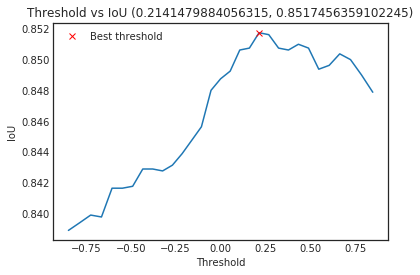

In [18]:
thrs = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thrs = np.log(thrs/(1-thrs)) 
ious = np.array([my_iou_metric_fuse_thrs(get_numpy(targets_pad), get_numpy(outputs_pad), get_numpy(outputs_resize), threshold) for threshold in tqdm_notebook(thrs)])

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thrs[threshold_best_index]

plt.plot(thrs, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [20]:
test_loader_resize = make_loader(x_test, num_workers=0, batch_size=64, mode='test', fit_method='resize')
test_loader_pad = make_loader(x_test, num_workers=0, batch_size=64, mode='test', fit_method='resize_pad')
model_resize.eval()
model_pad.eval()
output_resize_list = []
output_pad_list = []
with torch.no_grad():
    for inputs_resize, inputs_pad in tqdm_notebook(zip(test_loader_resize, test_loader_pad)):
        inputs_resize_1 = inputs_resize.permute(0,3,1,2).type(torch.FloatTensor).to(device)
        inputs_resize_2 = inputs_resize_1.flip(3)
        inputs_pad_1 = inputs_pad.permute(0,3,1,2).type(torch.FloatTensor).to(device)
        inputs_pad_2 = inputs_pad_1.flip(3)
        outputs_resize_1, _, _ = model_resize(inputs_resize_1)
        outputs_resize_2, _, _ = model_resize(inputs_resize_2)
        outputs_pad_1, _, _ = model_pad(inputs_pad_1)
        outputs_pad_2, _, _ = model_pad(inputs_pad_2)
        output_resize_list += [(outputs_resize_1+outputs_resize_2.flip(3))/2]
        output_pad_list += [(outputs_pad_1+outputs_pad_2.flip(3))/2]

In [21]:
outputs_pad = torch.cat(output_pad_list,0)
outputs_resize = torch.cat(output_resize_list,0)
outputs_pad_array = list(get_numpy(outputs_pad.squeeze(1)))
outputs_resize_array = list(get_numpy(outputs_resize.squeeze(1)))

In [22]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [26]:
pred_dict = {idx: rle_encode(recover_size_pad_resize(outputs_pad_array[i], outputs_resize_array[i], threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [27]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
submission_file = 'submission_{name}_{loss}_{mode}_{aug}.cvs'.format(name='resnext50',
                                                                 loss='bce_dice',
                                                                 mode='iou',
                                                                 aug='resize_pad_pad')
sub.to_csv(submission_file)